***Лабораторна робота<br>***
*Виконали студенти 3 курсу<br>
групи "Комп'ютерна математика"<br>
Демченко Андрій та Нікіфоров Олександр<br>*


Імпортуємо потрібні бібліотеки

In [720]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Глобальні змінні

In [721]:
N_TRAIN = 150
N_TEST = 20

***Пункт№1.***<br>
Загружаємо датасет та виводимо данні. Якщо уважно проаналізувати даний датасет, можна помітити що параметри датасета є нерівноцінними.

In [722]:
dataset = pd.read_csv('heart_failure_clinical_records_dataset.csv')
titles = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
          'ejection_fraction', 'high_blood_pressure', 'platelets',
          'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']
print(dataset.head())

FEATURE_NAMES = ['age', 'anaemia', 'high_blood_pressure', 'serum_sodium', 'sex', 'smoking']
size = len(FEATURE_NAMES)

x_df = np.array(dataset[FEATURE_NAMES]).reshape((299, size))
y_df = np.asarray(dataset['DEATH_EVENT'])

xy_shuffled = np.c_[x_df, y_df]
np.random.shuffle(xy_shuffled)

x_shuffled, y_shuffled = xy_shuffled[:, :size], xy_shuffled[:, size:]


    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

***Пункт№3.***<br>
Оптимізатор Momentum.<br>

In [723]:
class Momentum:
    def __init__(self, num_features=1, lr=0.01):
        self.m = np.zeros((num_features, 1))
        self.lr = lr

    def optimize_weights(self, weights, grads):
        self.m = (1 - self.lr) * self.m + self.lr * grads
        # new_weights = weights - self.lr * self.m
        new_weights = weights - self.m

        return new_weights

***Пункт№2.***<br>
Логістична регресія з регуляризацією L1.<br>

In [724]:
class LogR:
    def __init__(self, num_features=1, alpha=0.05):
        self.W = np.zeros((num_features, 1))
        self.M, self.V, self.t = 0, 0, 1
        self.optimizer = Momentum(num_features)
        self.eps = 0.001
        self.alpha = alpha
        # self.eps = 0

    def predict(self, X):
        y = 1 / (1 + np.exp(- (X @ self.W)))
        return y

    def predict_proba(self, X):
        y = self.predict(X)
        return np.where(y >= 0.5, 1, 0)

    def conv(self, arr):
        res = np.inf
        if len(arr) > 2:
            res = np.abs(np.mean(arr) - np.mean(arr[:-1]))
        return res

    def batch_split(self, X, Y, size):
        features = np.c_[X, Y]
        np.random.shuffle(features)
        features = np.array(np.split(features, range(size, features.shape[0], size)))
        return features

    def fit_batches(self, X, y_true, size=32, n_iters=10000, epsil=0.0001):
        n_iter = 0
        losses = []
        reg_losses = []
        while (n_iter < n_iters) and (self.conv(losses) > epsil):
            n_iter += 1
            current_losses = []
            current_reg_losses = []
            mini_batches = self.batch_split(X, y_true, size)
            for batch in mini_batches:
                x_small, y_small = batch[:, :-1], batch[:, -1].reshape(-1, 1)
                loss, grads, reg_loss = self.one_step_opt(x_small, y_small)
                current_losses.append(loss)
                current_reg_losses.append(reg_loss)
            losses.append(np.mean(current_losses))
            reg_losses.append(np.mean(current_reg_losses))
        return np.array(losses), np.array(reg_losses)

    def one_step_opt(self, X, y_true):
        grad_reg = self.alpha * np.sign(self.W)
        grad_reg[0, 0] = 0
        reg_loss = np.sum(self.alpha * np.abs(self.W)) ###
        grads = - X.T @ (y_true - X @ self.W) / X.shape[0] + grad_reg ###
        self.W = self.optimizer.optimize_weights(self.W, grads)

        loss = np.sum((y_true - self.predict(X)).T @ (y_true - self.predict(X))) / X.shape[0]
        return loss, grads, reg_loss

    def fit(self, x_train, y_train, n_iters=10000, epsil=0.00001):
        losses = []
        n_iter = 0
        while (n_iter < n_iters) and (self.conv(losses) > epsil):
            n_iter += 1
            t_loss, grads, reg_loss = self.one_step_opt(x_train, y_train)

            losses.append(t_loss)

        return losses

    def fit_and_check(self, x_train, y_train, x_valid, y_valid, n_iters=10000, epsil=0.00001):
        losses = []
        valid_losses = []
        reg_losses = []
        n_iter = 0
        while (n_iter < n_iters) and (self.conv(losses) > epsil):
            n_iter += 1
            t_loss, grads, reg_loss = self.one_step_opt(x_train, y_train)
            pr=self.predict(x_valid)
            losses.append(t_loss)
            reg_losses.append(reg_loss)
            v_loss = np.sum(-y_valid * np.log(pr + self.eps) -
                            (1 - y_valid) * np.log(1 - pr + self.eps)) / x_valid.shape[0]
            valid_losses.append(v_loss)

        y_true = self.predict_proba(x_valid)
        accuracy = np.sum(np.where(y_valid == y_true, 1, 0)) / y_valid.shape[0]
        y_t = self.predict(x_valid)
        return losses, valid_losses, reg_losses, accuracy


***Пункт№5.***<br>
Вчимо побудовану модель з параметром регуляризації 0 (без регуляризації) і переконуємось, що вона коректно навчилась.<br>
***Пункт№6.***<br>
Нормалізація данних min-max. Побудування моделі з пункта №5. Порівняння швидкостей. Графіки втрат по ітераціям.<br>

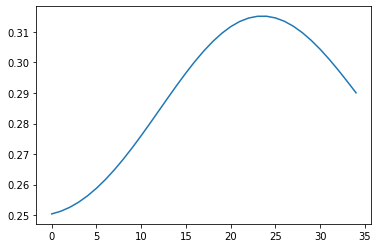

In [725]:
def normalize_std(X):
    min_f = np.amin(X, axis=0)
    max_f = np.amax(X, axis=0)
    result = (X - min_f) / (max_f - min_f)
    return result

x = normalize_std(x_shuffled)
y = y_shuffled[:]

x_train, y_train, = x[:N_TRAIN], y[:N_TRAIN].reshape(N_TRAIN, 1)
x_test, y_test = x[N_TRAIN:N_TRAIN + N_TEST], y[N_TRAIN:N_TRAIN + N_TEST].reshape(N_TEST, 1)

lr = LogR(num_features=size, alpha=0)
losses = lr.fit(x_train, y_train)
plt.plot(losses)
plt.show()



***Пункт№4.***<br>
Реалізуємо mini-batch навчання з розміром батча B=32.<br>

<ipython-input-724-5ca935f76025>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  features = np.array(np.split(features, range(size, features.shape[0], size)))


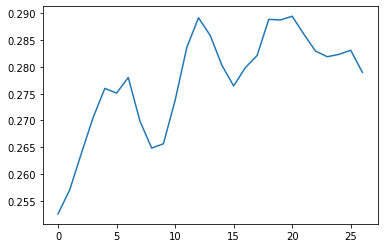

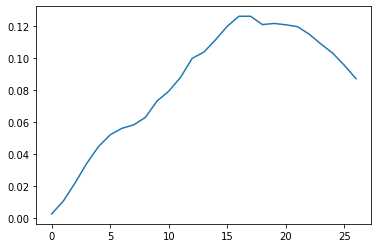

In [726]:
BATCH_SIZE = 32
lr = LogR(num_features=size, alpha=0.1)
losses, reg_losses = lr.fit_batches(x_train, y_train, size=BATCH_SIZE)

plt.figure(1);
plt.plot(losses)
plt.figure(2);
plt.plot(reg_losses)
plt.show()

***Пункт№7.***<br>
Реалізація оцінки точності за допомогою метода кросс-валідації з K=5 фолдами, без регуляризації.

In [727]:
def create_fold(X, Y, folds, k):
    features = np.c_[X, Y]
    r = int(features.shape[0] / folds)
    x1 = np.array([]) if k == 0 else features[0:k * r, :]
    x3 = np.array([]) if k == r - 1 else features[k * r + r:, :]

    xy_valid = features[k * r:(k * r + r), :]

    if k == 0: xy_train = x3
    elif k == r - 1: xy_train = x1
    else: xy_train = np.concatenate([x1, x3], axis=0)

    x_train, y_train = xy_train[:, :-1], xy_train[:, -1].reshape(-1, 1)
    x_test, y_test = xy_valid[:, :-1], xy_valid[:, -1].reshape(-1, 1)

    return x_train, y_train, x_test, y_test



***Пункт№8.***<br>
Побудова залежності ваг регресії від коефіцієнтів регуляризації.<br>
***Пункт№9.***<br>
Побудова залежності точності від коефіцієнтів регуляризації.<br>

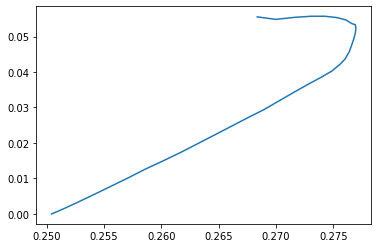

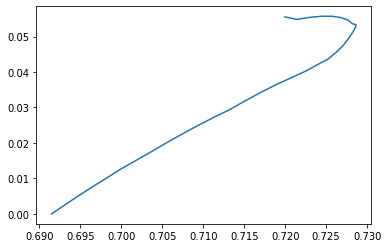

In [728]:
lr = LogR(num_features=size, alpha=0.1)
losses, valid_losses, reg_losses, accuracy = lr.fit_and_check(x_train, y_train, x_test, y_test)

plt.figure(1)
plt.plot(np.array(losses), np.array(reg_losses))
plt.figure(2)
plt.plot(np.array(valid_losses), np.array(reg_losses))
plt.show()


***Пункт№10.***<br>
Покращення

In [728]:
# TODO


***Пункт№11.***<br>
Висновки

